#Assignment04. Origin-Destination Analysis with NetworkX

##Install and Import Packages

In [1]:
# Install packages

!pip install fiona
!pip install geopandas
!pip install folium
!pip install sodapy -q
!pip install adjustText
!pip install plotly --upgrade
!pip install contextily
!pip install mapclassify
!pip install chart-studio
!sudo apt install libspatialindex-dev
!pip install rtree
!pip install pygeos

     |████████████████████████████████| 15.4 MB 2.0 MB/s 
     |████████████████████████████████| 1.0 MB 4.4 MB/s 
     |████████████████████████████████| 6.3 MB 6.5 MB/s 
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=d86e7101e9c153dd10432401110da68bf9dd10391d9b04a64e60456b3b74b3ce
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText
     |████████████████████████████████| 25.3 MB 2.9 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 19.3 MB 49.4 MB/s 
     |████████████████████████████████| 64 kB 1.2 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW 

In [2]:
!pip install decorator
!pip install pandapower

     |████████████████████████████████| 5.8 MB 4.8 MB/s 
     |████████████████████████████████| 149 kB 9.8 MB/s 
     |████████████████████████████████| 3.6 MB 25.4 MB/s 
  Created wheel for pandapower: filename=pandapower-2.7.0-py3-none-any.whl size=5777359 sha256=3924c41f1f3348af5887db607991aa2618d2b84f41643e8fef1c07ff763a3dbc
  Stored in directory: /root/.cache/pip/wheels/ff/e6/b6/c9218d5a45a02f4bdb220272f2bac4f59c5b73ed08a08125c3
Successfully built pandapower


In [3]:
# Import packages
# To ignore unimporant system warnings
import warnings
warnings.filterwarnings("ignore")

# We will use Pandas, Numpy, and Matplotlib which is a package for visualization with Python
import pandas as pd
import numpy as np

# Load a required package 
# This is a library for accessing and parsing data through URLs
from urllib.parse import urlencode
import urllib.request, json 
from bs4 import BeautifulSoup # for web scraping
import fiona
import plotly.express as px
import geopandas as gpd
import adjustText as aT
import seaborn as sns # visualization styling package
import plotly.graph_objects as go
import urllib, json
import chart_studio.plotly as py
import chart_studio.tools as tls
import os
import plotly
from sodapy import Socrata
from IPython.display import Image, display
from shapely.geometry import shape
from shapely.geometry import Point 
from shapely.geometry import Polygon
import time
from shapely.geometry import shape
import contextily as ctx
from google.colab import files
from sklearn.preprocessing import MinMaxScaler

import networkx as nx #library supporting networks

%matplotlib inline 
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt
import seaborn as sns # visualization styling package
import folium
from folium.plugins import HeatMap

#Chart Studio API
import chart_studio
username='bkirthi'
api_key='PHHYaOZKZDA7BF3nUUtO'
chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

In [4]:
# import more packages
import plotly.io as pio
pio.renderers.default = "colab"
access_token = 'pk.eyJ1IjoiYmtpcnRoaSIsImEiOiJja3VpdzFiMnoycnYyMzBtYXM1aW1uemd0In0.knHw7eYrN8DvrrBHZugW8Q'
px.set_mapbox_access_token(access_token) # for interactive plotly viz

import plotly.graph_objects as go
import chart_studio.plotly as py
import chart_studio.tools as tls

##Import Citibike Rideshare Data
Downloadable from https://www.citibikenyc.com/system-data. Click “Downloadable files of Citi Bike trip data” or “Download Citi Bike trip history data”.

Here, download the data for febust 2021.


In [5]:
# clone github
!git clone https://github.com/kirthi-b/CitiBike-NetworkX

Cloning into 'CitiBike-NetworkX'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 32 (delta 10), reused 24 (delta 5), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [6]:
feb = pd.read_csv("/content/CitiBike-NetworkX/Data/202102.csv")

In [7]:
feb.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,121DD7DD23CB1335,docked_bike,2021-02-03 23:11:28,2021-02-03 23:18:28,Hoboken Ave at Monmouth St,JC105,Christ Hospital,JC034,40.735208,-74.046964,40.734786,-74.050444,member
1,FD73FB85F008349D,docked_bike,2021-02-27 16:34:05,2021-02-27 16:56:40,Newport Pkwy,JC008,Marin Light Rail,JC013,40.728744,-74.032108,40.714584,-74.042817,member
2,39F9E6663CB5FDF6,docked_bike,2021-02-26 23:16:04,2021-02-26 23:22:25,Journal Square,JC103,Baldwin at Montgomery,JC020,40.733670,-74.062500,40.723659,-74.064194,member
3,A64745CB0792EC6F,docked_bike,2021-02-24 16:51:50,2021-02-24 17:16:09,Hoboken Ave at Monmouth St,JC105,Hoboken Ave at Monmouth St,JC105,40.735208,-74.046963,40.735208,-74.046964,casual
4,75CC76EB9543764A,docked_bike,2021-02-24 20:44:16,2021-02-24 20:44:46,Hoboken Ave at Monmouth St,JC105,Hoboken Ave at Monmouth St,JC105,40.735208,-74.046963,40.735208,-74.046964,member


In [8]:
print(feb.shape)

(4881, 13)


In [9]:
feb = feb[['ride_id','started_at','ended_at','start_station_name','end_station_name','start_lat','start_lng','end_lat','end_lng']]

In [10]:
feb_sub = feb[['start_station_name','start_lat','start_lng']]
feb_sub.shape[0]

4881

In [11]:
feb_rev = feb[['end_station_name','end_lat','end_lng']]
feb_rev = feb_rev.rename(columns={"end_station_name":"start_station_name","end_lat":"start_lat","end_lng":"start_lng"})
feb_rev.shape[0]

4881

In [12]:
#get count of rides per route
feb_count = feb.groupby(['start_station_name','end_station_name']).size().to_frame('count').reset_index()
feb_df = pd.DataFrame(feb_count)
feb_count.head()

,start_station_name,end_station_name,count
0,5 Corners Library,5 Corners Library,3
1,5 Corners Library,Brunswick St,1
2,5 Corners Library,Christ Hospital,2
3,5 Corners Library,City Hall,1
4,5 Corners Library,Columbus Drive,1


In [13]:
#get list of all routes
tot = pd.concat([feb_sub,feb_rev])
tot_count = tot.groupby(['start_station_name']).size().to_frame('count').reset_index()
tot_df = pd.DataFrame(tot_count)
tot_df.head()

,start_station_name,count
0,5 Corners Library,59
1,Astor Place,106
2,Baldwin at Montgomery,158
3,Bergen Ave,58
4,Bloomfield St & 15 St,1


In [14]:
tot.shape[0]

9762

In [15]:
tot = tot.drop_duplicates()
tot.shape[0]

139

In [16]:
tot = pd.merge(tot, tot_df, on="start_station_name")

In [17]:
tot.head()

,start_station_name,start_lat,start_lng,count
0,Hoboken Ave at Monmouth St,40.735208,-74.046964,84
1,Hoboken Ave at Monmouth St,40.735208,-74.046963,84
2,Hoboken Ave at Monmouth St,40.735208,-74.046964,84
3,Newport Pkwy,40.728744,-74.032108,595
4,Newport Pkwy,40.728745,-74.032108,595


##Create a Network with CitiBike Station Names as Nodes

In [18]:
#create a dictionary of station locations
stations={}
for c in range(len(tot)):
    stations[tot['start_station_name'][c]]=(tot['start_lng'][c],tot['start_lat'][c])

In [19]:
stations

{'5 Corners Library': (-74.05950307846071, 40.73496102000952),
 'Astor Place': (-74.07126188278198, 40.71928220070703),
 'Baldwin at Montgomery': (-74.0641943, 40.7236589),
 'Bergen Ave': (-74.07145500183104, 40.72210378668603),
 'Bloomfield St & 15 St': (-74.02658000000001, 40.754529999999995),
 'Brunswick & 6th': (-74.0503889322281, 40.726011729646245),
 'Brunswick St': (-74.05065640000001, 40.7241765),
 'Christ Hospital': (-74.050443636, 40.734785818),
 'City Hall': (-74.04384499999999, 40.717732500000004),
 'Cleveland Pl & Spring St': (-73.99724900722505, 40.72210378668603),
 'Columbus Dr at Exchange Pl': (-74.03281, 40.71687),
 'Columbus Drive': (-74.03891444206238, 40.71835519823214),
 'Communipaw & Berry Lane': (-74.06661093235016, 40.71435836870427),
 'Dey St': (-74.066921, 40.737711),
 'Dixon Mills': (-74.04996782541275, 40.72163014263835),
 'Essex Light Rail': (-74.03648570000001, 40.712774200000005),
 'Fairmount Ave': (-74.07195925712584, 40.72572613742557),
 'Glenwood Ave':

In [20]:
#create a network with station names as nodes for febust
feb_rides=nx.DiGraph()
feb_rides.add_nodes_from(feb['start_station_name'])

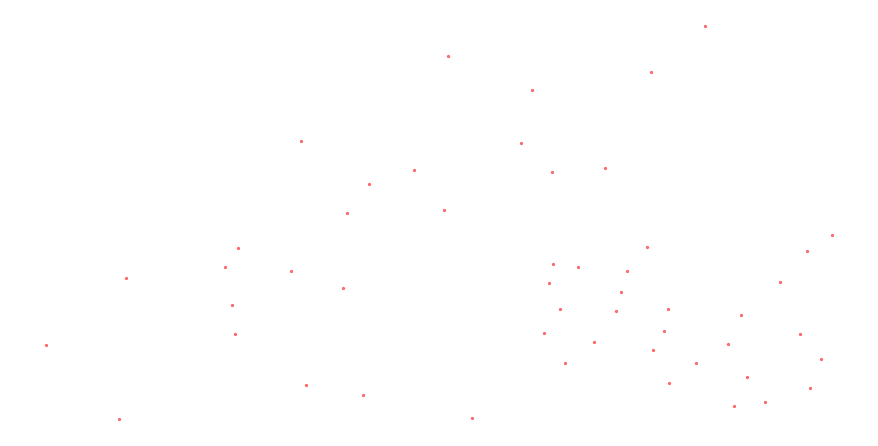

In [21]:
#visualize all the world airport cities
plt.figure(figsize = (12,6))
nx.draw(feb_rides, pos=stations, with_labels=False, arrows=False, node_size=5,
       node_color='red', alpha=0.5)

##Add Edges

In [22]:
# create list of edges as tuples
# create list of 0 first

#for febust
feb_EN=len(feb_df.index)
edgelist=[0]*feb_EN
print (edgelist[:5])

[0, 0, 0, 0, 0]


In [23]:
# create list of edges as tuples for febust
for j in range(0,feb_EN):
    edgelist[j]=(feb_df['start_station_name'][j],feb_df['end_station_name'][j], feb_df['count'][j])
edgelist

[('5 Corners Library', '5 Corners Library', 3),
 ('5 Corners Library', 'Brunswick St', 1),
 ('5 Corners Library', 'Christ Hospital', 2),
 ('5 Corners Library', 'City Hall', 1),
 ('5 Corners Library', 'Columbus Drive', 1),
 ('5 Corners Library', 'Dey St', 1),
 ('5 Corners Library', 'Fairmount Ave', 1),
 ('5 Corners Library', 'Grove St PATH', 3),
 ('5 Corners Library', 'Hamilton Park', 1),
 ('5 Corners Library', 'Hilltop', 2),
 ('5 Corners Library', 'Manila & 1st', 1),
 ('5 Corners Library', 'McGinley Square', 5),
 ('5 Corners Library', 'Montgomery St', 1),
 ('5 Corners Library', 'Newark Ave', 1),
 ('5 Corners Library', 'Newport PATH', 1),
 ('5 Corners Library', 'Newport Pkwy', 4),
 ('5 Corners Library', 'Pershing Field', 3),
 ('5 Corners Library', 'Washington St', 1),
 ('5 Corners Library', 'York St', 1),
 ('Astor Place', 'Astor Place', 1),
 ('Astor Place', 'Bergen Ave', 1),
 ('Astor Place', 'Fairmount Ave', 2),
 ('Astor Place', 'Grove St PATH', 3),
 ('Astor Place', 'Hamilton Park', 1),

In [24]:
# add edges to the network
feb_rides.add_weighted_edges_from(edgelist)

In [25]:
print (feb_rides.in_degree(weight='weight')['Newport PATH'])
print (feb_rides.out_degree(weight='weight')['Newport PATH'])

218
204


###Incoming and outgoing degree

In [26]:
# Convert pandas dataframe and join two information - febust
in_degree = pd.DataFrame.from_dict(dict(feb_rides.in_degree()), orient='index').reset_index()
in_degree.columns = ['start_station_name', 'in_degree']
out_degree = pd.DataFrame.from_dict(dict(feb_rides.out_degree()), orient='index').reset_index()
out_degree.columns = ['start_station_name', 'out_degree']

in_degree.head()

,start_station_name,in_degree
0,Hoboken Ave at Monmouth St,13
1,Newport Pkwy,34
2,Journal Square,22
3,Newark Ave,38
4,5 Corners Library,17


In [27]:
in_out_degree = pd.merge(in_degree, out_degree, how='outer', on='start_station_name')
in_out_degree.sort_values(by='in_degree', ascending=False).head(10)

,start_station_name,in_degree,out_degree
38,Grove St PATH,43,35
34,Hamilton Park,39,36
48,City Hall,38,35
3,Newark Ave,38,34
30,Newport PATH,36,30
29,JC Medical Center,35,31
1,Newport Pkwy,34,34
41,Columbus Dr at Exchange Pl,33,27
42,Van Vorst Park,33,27
5,Washington St,32,29


In [28]:
print(feb_rides.in_degree())
print(feb_rides.out_degree())

[('Hoboken Ave at Monmouth St', 13), ('Newport Pkwy', 34), ('Journal Square', 22), ('Newark Ave', 38), ('5 Corners Library', 17), ('Washington St', 32), ('Montgomery St', 30), ('York St', 19), ('Marin Light Rail', 32), ('Morris Canal', 22), ('Communipaw & Berry Lane', 12), ('Monmouth and 6th', 29), ('Baldwin at Montgomery', 19), ('Liberty Light Rail', 27), ('Pershing Field', 21), ('Heights Elevator', 10), ('Astor Place', 15), ('Sip Ave', 25), ('McGinley Square', 24), ('Jackson Square', 9), ('Harborside', 32), ('Paulus Hook', 23), ('Warren St', 32), ('Union St', 4), ('Glenwood Ave', 14), ('Bergen Ave', 8), ('Oakland Ave', 13), ('Hilltop', 22), ('Jersey & 3rd', 25), ('JC Medical Center', 35), ('Newport PATH', 36), ('Lafayette Park', 15), ('Brunswick St', 31), ('Brunswick & 6th', 23), ('Hamilton Park', 39), ('Dey St', 6), ('Riverview Park', 10), ('Fairmount Ave', 13), ('Grove St PATH', 43), ('Grand St', 30), ('Christ Hospital', 12), ('Columbus Dr at Exchange Pl', 33), ('Van Vorst Park', 3

###Visualize the Citibike Routes Network

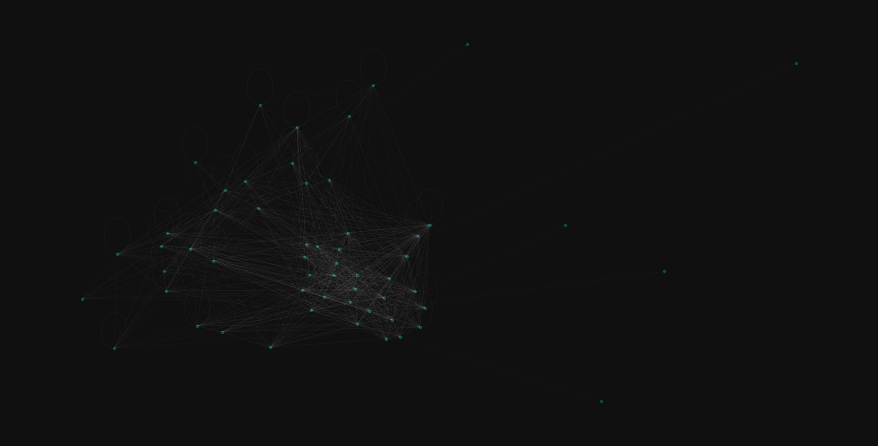

In [40]:
#visualize the network
fig = plt.figure(figsize = (12,6))
nx.draw(feb_rides, pos=stations, with_labels=False, arrows=False, node_size=5,
       node_color='cyan', alpha=0.2, style='dotted', edge_color='white', width=0.2)
fig.set_facecolor("#101010")

In [41]:
fig = px.scatter_mapbox(tot,
                    lat='start_lat',
                    lon='start_lng',
                        color_discrete_sequence=px.colors.qualitative.Pastel,
                       mapbox_style='dark',
                        size = 'count',
                        hover_data = {'start_station_name': True})

fig.update_layout(autosize=False,
                 width=1000,
                 height=800)

fig.update_layout(mapbox_zoom=10, 
                  mapbox_center = {"lat": 40.776789, "lon": -73.970212})
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [42]:
py.plot(fig, filename="citibike_feb", auto_open = True)

'https://plotly.com/~bkirthi/46/'

##Check other centrality scores of stations
* Degree centrality
* Eigenvector centrality

In [31]:
#output top ten centrality scores, given the dictionary d
def topdict(d,tn):
#     ind=sorted(d, key=dict(d).get, reverse=True)
    ind = sorted(dict(c1), key=dict(c1).__getitem__, reverse=True)
    for i in range(0,tn):
        print('{0}|{1}:{2}'.format(i+1,ind[i],d[ind[i]]))

Now compute five centrality metrics - degree, eigenvector, betweenness, closeness and pagerank - and output top 10 stations in terms according to those metrics

In [32]:
# Degree centrality
c1= nx.degree(feb_rides)
topdict(c1,10)

1|Grove St PATH:78
2|Hamilton Park:75
3|City Hall:73
4|Newark Ave:72
5|Newport Pkwy:68
6|Marin Light Rail:67
7|JC Medical Center:66
8|Newport PATH:66
9|Harborside:63
10|Warren St:62


In [33]:
# Eigenvector centrality
c2= nx.eigenvector_centrality(feb_rides)
topdict(c2,10)

1|Grove St PATH:0.22116844006053107
2|Hamilton Park:0.21598518683732237
3|City Hall:0.2157350269161693
4|Newark Ave:0.20711733306663122
5|Newport Pkwy:0.1961873284344003
6|Marin Light Rail:0.1923874299681982
7|JC Medical Center:0.201581447151761
8|Newport PATH:0.2063060760589472
9|Harborside:0.1990412119844621
10|Warren St:0.1949105451876368


In [34]:
#Betweenness centrality
c3 = nx.betweenness_centrality(feb_rides)
topdict(c3,10)

1|Grove St PATH:0.03446822695398005
2|Hamilton Park:0.031315067367264714
3|City Hall:0.026888621033723116
4|Newark Ave:0.023655299005055624
5|Newport Pkwy:0.024343772309808824
6|Marin Light Rail:0.04810786630089737
7|JC Medical Center:0.01993912378869629
8|Newport PATH:0.014654501159347614
9|Harborside:0.017756821778785053
10|Warren St:0.013781499626316378


In [35]:
#Closeness centrality
c4 = nx.closeness_centrality(feb_rides)
topdict(c4,10)

1|Grove St PATH:0.7836990595611284
2|Hamilton Park:0.7331378299120234
3|City Hall:0.7215007215007214
4|Newark Ave:0.7215007215007214
5|Newport Pkwy:0.6784260515603799
6|Marin Light Rail:0.6587615283267457
7|JC Medical Center:0.6887052341597796
8|Newport PATH:0.6993006993006993
9|Harborside:0.6587615283267457
10|Warren St:0.6587615283267457


##Visualize the network with the node size proportional to the degree centrality (or any other centrality)

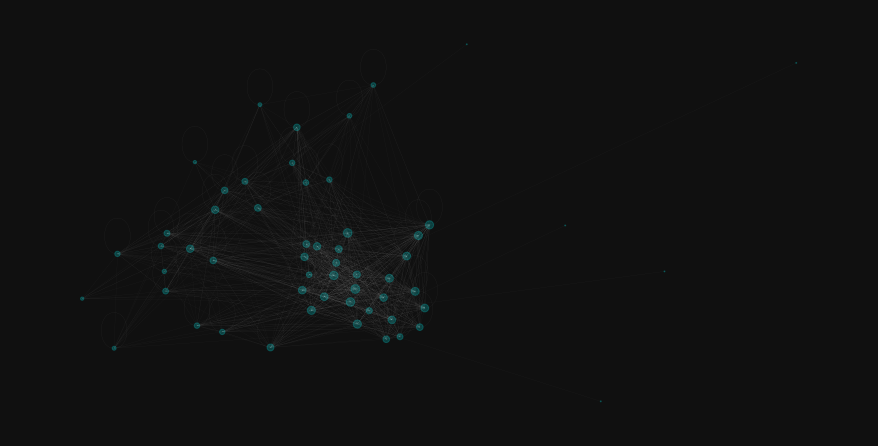

In [38]:
node_size_original = list(dict(c1).values()) # based on degree centrality

#visualize the network
fig = plt.figure(figsize = (12,6))
nx.draw(feb_rides, pos=stations, with_labels=False,arrows=False, 
        node_size=node_size_original, 
       node_color='cyan', alpha=0.2, style='dotted', edge_color='white', width=0.2)
fig.set_facecolor("#101010")